In [1]:
import numpy as np
import ot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import multivariate_normal
import seaborn as sn
import pandas as pd
from pathlib import Path
from sklearn.utils import check_random_state
from scipy.spatial.distance import cdist
# User functions
from utils import W2_dist, BaseTransport, GaussianTransport, get_trajectories_for_plotting, \
                  calc_parsimony, get_desiderata

# We will be using data from  the UCI: Gas sensor array under dynamic gas mixtures Data Set
# Link: https://archive.ics.uci.edu/ml/datasets/gas+sensor+array+under+dynamic+gas+mixtures
data_dir = Path('data')
path_customer_profiles = open('./Results_Experiments/File_Paths/path_customer_profiles.txt','r').read()
path_shift_explanations = open('./Results_Experiments/File_Paths/path_shift_explanations.txt','r').read()
path_transport_graphics = open('./Results_Experiments/File_Paths/path_transport_graphics.txt','r').read()
path_distances = open('./Results_Experiments/File_Paths/path_distances.txt','r').read()

In [2]:
import os
print(os.getcwd())  # Zeigt das aktuelle Arbeitsverzeichnis an

/Users/ericduhme/Documents/UNI/PAMI/PAMI_Projekt/Shift_Explanation


In [3]:
# Experiment hyperparamters
rng = np.random.RandomState(42)



In [4]:
# Setting so that the plots look normal even when using dark-reader
sn.set_style("whitegrid")
sn.set_context(context="paper", font_scale=2)
pal = sn.color_palette("Set1")

# Setting up specifics for plotting + saving
save_figures = True
add_legend = False
add_title = False
add_axis = False
save_parms = {'format': 'pdf','bbox_inches':'tight', 'pad_inches':0}
line_parms = {'linewidth':4, 'color':'k'}
if save_figures:  # saves all figures in a figure directory in the local directory
    figure_dir = Path('.') / 'figures' / 'adult-income-experiment'
    if not figure_dir.exists():
        figure_dir.mkdir(parents=True)

In [5]:
!dir $data_dir

zsh:1: command not found: dir


## Loading and Preprocessing the data


In [6]:
# Parameters
comparison_id = None

In [7]:
# Parameters
comparison_id = 2


In [8]:
from data_utils import load_and_preprocess_logistics_data
continuous_variables_indicies = [0,1,2]
# Pick the desired dataset combination
comparison_dict = {0: [0,1], 1: [2,3], 2: [4,5]}
# comparison_id = 1
# n_samples = 'balanced'
n_samples = 1000
equal_week_split = True

X, Y, feature_names = load_and_preprocess_logistics_data(
            data_dir, rng, n_samples, return_column_names=True,equal_week_split=equal_week_split, comparison_id=
            comparison_id, comparison_dict=comparison_dict)
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
print(feature_names)
print(X)
print(Y)



../Shift_Explanation/Results_Experiments/Test/Customer_Profiles/customer_profile_4.csv
Comparing customer_profile_4 and customer_profile_5
Finished preprocessing logistic dataset. Split on customer_profile_4 and customer_profile_5 with resulting source shape: (996, 3), target shape: (996, 3).
['Connection', 'Weight', 'Unit_type']
[[ 3.          5.6933527  20.        ]
 [ 4.         38.56840289 20.        ]
 [20.          4.00626176 20.        ]
 ...
 [14.          3.         20.        ]
 [16.         31.87682169 20.        ]
 [16.         20.89960064 20.        ]]
[[18.         11.30001663 20.        ]
 [ 9.          7.04185576 20.        ]
 [16.         23.89041903 20.        ]
 ...
 [ 7.          5.43754375 20.        ]
 [ 4.         33.21469912 20.        ]
 [12.         36.17879601 20.        ]]


## Performing Clustering

In [9]:
def get_mixed_variable_desiderata(X_continuous, Y_continuous, Z, standardizer, continuous_variables_indicies,
                                  n_expectation=10, inter=None, rng=None):
    rng = check_random_state(rng)
    non_continuous_variables_indicies = np.delete(np.arange(X.shape[1]), continuous_variables_indicies)
    fids = np.zeros(n_expectation)
    pars = np.zeros(n_expectation)
    for loop_idx in range(n_expectation):
        # since Z is in a pseudo continuous space, we project it to a discrete space using the phase change graph defined within Z
        # since the Z[i, j_descrete] is probability of that point being positive
        Z_projected_discrete = Z.copy()
        uniform_vars = rng.uniform(size=(Z.shape[0], len(non_continuous_variables_indicies)))
        positive_probability = Z[:, non_continuous_variables_indicies]
        # Z_projected_discrete[:, non_continuous_variables_indicies] = (uniform_vars <= positive_probability).astype(Z.dtype)
        Z_projected_continous = standardizer.transform(Z_projected_discrete)
        # Calculating fidelity
        M = cdist(Y_continuous, Z_projected_continous, 'sqeuclidean')
        a,b = ot.utils.unif(X.shape[0]), ot.utils.unif(Z.shape[0])
        fid = ot.emd2(a, b, M)
        # Calculating parsimony
        par = calc_parsimony(X_continuous, Z_projected_continous)
        # recording
        fids[loop_idx] = fid
        pars[loop_idx] = par
    fid, par = fids.mean(), pars.mean()
    if inter is not None:
        print(f'Fid: {fid:.3f}, Par: {par:.3f}, Inter: {inter}')
    return fid, par, inter

In [10]:
def mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_vars):
    non_continuous_vars = np.delete(np.arange(X_cluster.shape[1]), continuous_variables_indicies)
    X_cluster_pushed = X_cluster.copy()
    X_cluster_means = X_cluster.mean(axis=0)
    Z_cluster_means = Z_cluster.mean(axis=0)
    X_cluster_pushed[:, continuous_vars] += Z_cluster_means[continuous_vars] - X_cluster_means[continuous_vars]
    X_cluster_pushed[:, non_continuous_vars] = Z_cluster_means[non_continuous_vars]  # sets T(X_discrete) to Pr(Z_discrete = 1)
    return X_cluster_pushed

In [11]:
## Hyperparameters
max_clusters = 10

In [12]:
# Increasing the number of clusters to see the increase in fidelity and decrease in interpretability

cluster_histories = []

# fitting standardizer on our source domain
standardizer = standardizer.fit(X)

# Finding base desiderata values for T=id
X_continuous, Y_continuous = standardizer.transform(X), standardizer.transform(Y)
fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, X, standardizer, continuous_variables_indicies,
                                                n_expectation=1, inter=0, rng=rng)  # showing the base desiderata
fids = np.zeros(max_clusters+1)
fids[0] = fid
pars = np.zeros(max_clusters+1)
pars[0] = par
inters = np.zeros(max_clusters+1)
inters[0] = 0

################################################################################################################################################
T = BaseTransport(X, Y, fit=True)
Z = T.forward(X, Y)
Z_continuous = standardizer.transform(Z)

for n_clusters in range(1, max_clusters+1):
     # performs paired clustering in a continuous joint X,Z space
    cluster_labels = T._pair_clustering(X_continuous, Z=Z_continuous, n_clusters=n_clusters, rng=rng) 
    
    Z_clusters = np.zeros_like(Z)  # the final output of the cluster mean shift transport
    for cluster_idx in range(n_clusters):
        X_cluster = X[cluster_labels == cluster_idx]
        Z_cluster = Z[cluster_labels == cluster_idx]
        # A method similar for cluster mean shift transport, but with accounting for binary variables
        X_cluster_pushed = mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_variables_indicies)
        Z_clusters[cluster_labels == cluster_idx] = X_cluster_pushed
        
    # getting desiderata information
    fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, Z_clusters, standardizer, 
                                                    continuous_variables_indicies, n_expectation=30,
                                                    inter=n_clusters, rng=rng)
    fids[n_clusters] = fid
    pars[n_clusters] = par
    inters[n_clusters] = n_clusters

    cluster_record = {
        'labels': cluster_labels.copy(),
        'Z_clusters': Z_clusters.copy(),
        'n_clusters': n_clusters
    }
    cluster_histories.append(cluster_record)

Fid: 0.097, Par: 0.000, Inter: 0


Fid: 0.065, Par: 32.318, Inter: 1


Fid: 0.058, Par: 37.948, Inter: 2


Fid: 0.055, Par: 40.584, Inter: 3


Fid: 0.053, Par: 42.594, Inter: 4


Fid: 0.053, Par: 41.914, Inter: 5


Fid: 0.050, Par: 47.258, Inter: 6


Fid: 0.043, Par: 52.472, Inter: 7


Fid: 0.044, Par: 51.502, Inter: 8


Fid: 0.030, Par: 64.356, Inter: 9


Fid: 0.040, Par: 54.759, Inter: 10


In [13]:
# changing fidelity to be % of shift explained
def calc_percent_explained(x):
    return 100*(max_fid - x) / max_fid
max_fid = fids[0]
percent_explained = np.apply_along_axis(calc_percent_explained, 0, fids)

Results with splitting on customer_profile_4 and customer_profile_5:


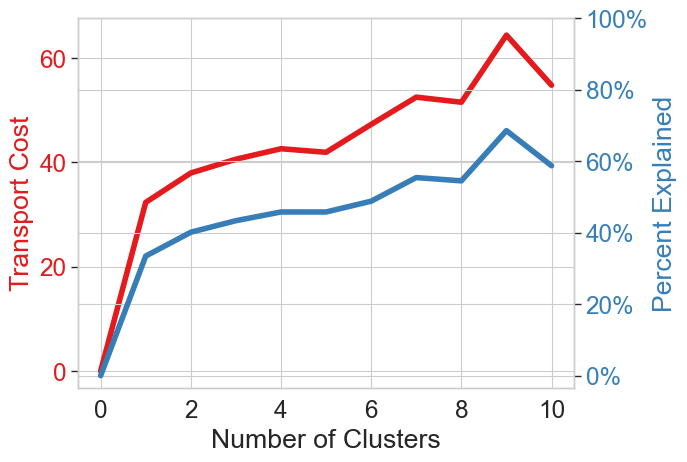

In [14]:
# Create Plot
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Number of Clusters') 
ax1.set_ylabel('Transport Cost', color = pal[0]) 
ax1.plot(np.arange(max_clusters+1), pars, color = pal[0],
         **{k:v for (k,v) in line_parms.items() if k != 'color'})  
ax1.tick_params(axis ='y', labelcolor = pal[0]) 
# Adding Twin Axes
ax2 = ax1.twinx() 
ax2.set_ylabel('Percent Explained', color = pal[1]) 
ax2.plot(np.arange(max_clusters+1), percent_explained, color = pal[1],
         **{k:v for (k,v) in line_parms.items() if k != 'color'}) 
ax2.tick_params(axis ='y', labelcolor = pal[1]) 
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_ylim(None, 100)



print(f'Results with splitting on customer_profile_{comparison_dict[comparison_id][0]} and customer_profile_{comparison_dict[comparison_id][1]}:')
if save_figures: plt.savefig(
    f'../{path_transport_graphics}/logitics_data_on_customer_profile_{comparison_dict[comparison_id][0]} and customer_profile_{comparison_dict[comparison_id][1]}--clustering-results.{save_parms["format"]}',
    **save_parms
    )
plt.show()

In [15]:
customer_profile_0_means = {}
customer_profile_1_means = {}


for record_idx in range(max_clusters):
    cluster_record = cluster_histories[record_idx]
    Z_clusters = cluster_record['Z_clusters']
    labels = cluster_record['labels']
    n_clusters = cluster_record['n_clusters']
    print(f'Starting {n_clusters} cluster results:')

    src_means = []
    tgt_means = []

    tgt = f'customer_profile_{comparison_dict[comparison_id][1]}'
    src = f'customer_profile_{comparison_dict[comparison_id][0]}'
    with np.printoptions(precision=3, suppress=True):
        for cluster_idx in range(n_clusters):
            print(f'\tCluster: {cluster_idx}')
            print(f'\t\t\t\t     Names={[name[:3] for name in feature_names]}')
            src_mean = X[cluster_idx == labels].mean(axis=0)
            tgt_mean = Z_clusters[cluster_idx == labels].mean(axis=0)
            print(f'\t\t   {src}_mean={src_mean}')
            print(f'\t\tT({tgt})_mean={tgt_mean}')

            customer_profile_0_means[n_clusters] = src_means
            customer_profile_1_means[n_clusters] = tgt_means
            src_means.append(src_mean)
            tgt_means.append(tgt_mean)
        print()



Starting 1 cluster results:
	Cluster: 0
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_4_mean=[10.608 21.531 20.   ]
		T(customer_profile_5)_mean=[ 9.512 21.659 20.   ]

Starting 2 cluster results:
	Cluster: 0
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_4_mean=[15.792 21.495 20.   ]
		T(customer_profile_5)_mean=[14.26  21.706 20.   ]
	Cluster: 1
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_4_mean=[ 4.945 21.57  20.   ]
		T(customer_profile_5)_mean=[ 4.326 21.608 20.   ]

Starting 3 cluster results:
	Cluster: 0
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_4_mean=[16.25  14.743 20.   ]
		T(customer_profile_5)_mean=[14.557 14.502 20.   ]
	Cluster: 1
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_4_mean=[ 4.703 16.16  20.   ]
		T(customer_profile_5)_mean=[ 4.248 16.079 20.   ]
	Cluster: 2
				     Names=['Con', 'Wei', 'Uni']
		   customer_profile_4_mean=[10.78 33.43 20.  ]
		T(customer_profile_5)_mean=[ 9.65  34.125 20.   ]

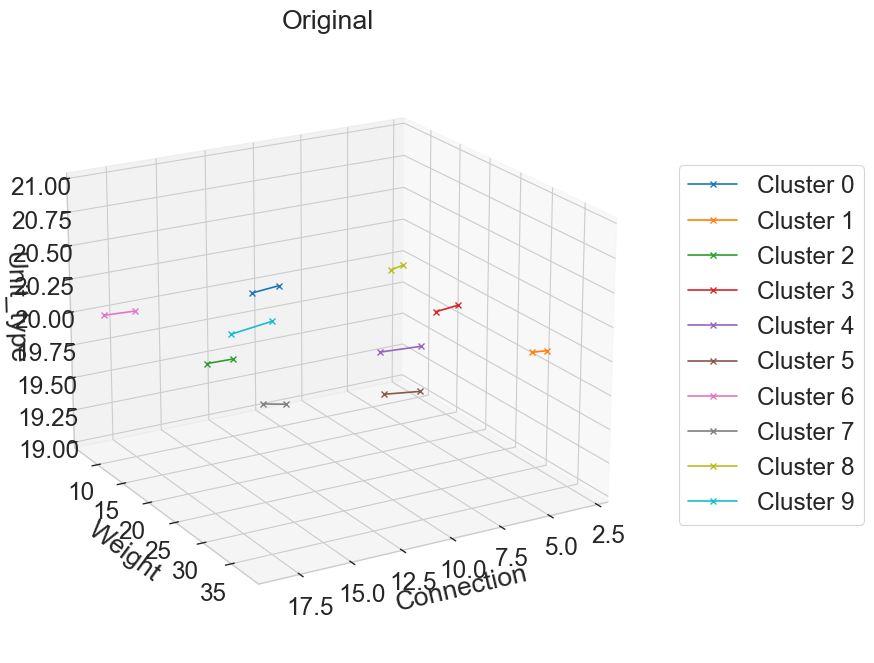

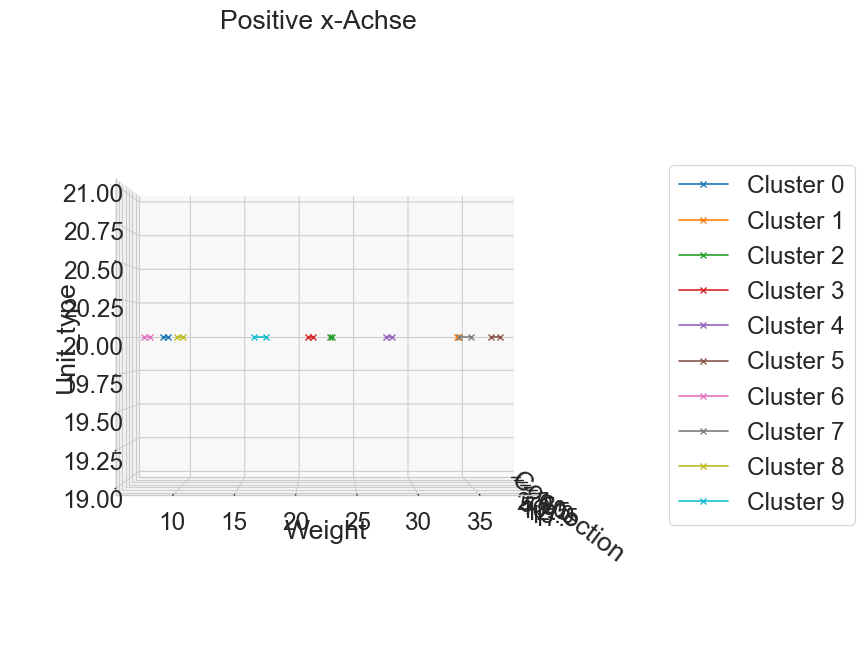

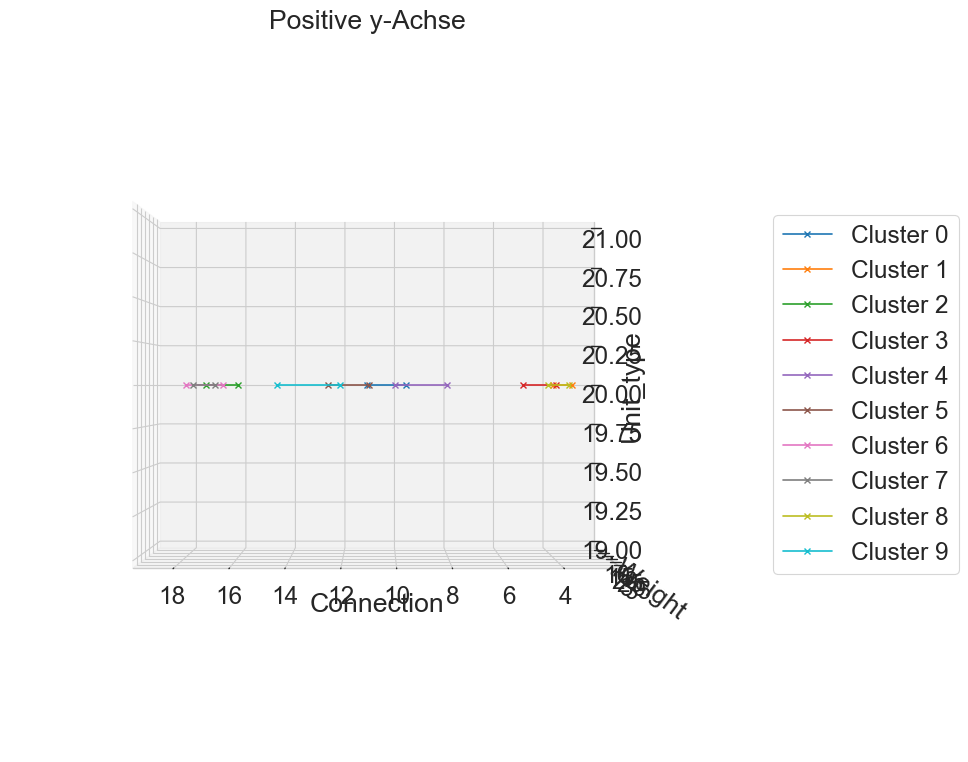

,Dataset,C_max,K,V_max,lambd,sim_weeks,UT_list,weight_span,num_components,number_of_connections
4,4,20,50,50,0.1,6,"[20, 20, 20, 20, 20, 20]","[3, 40]",3.0,5.0
5,5,20,50,50,0.1,6,"[20, 20, 20, 20, 20, 20]","[3, 40]",3.0,5.0


,Cluster,Total_distance,Connections_diff,Weight_diff,Unit_diff
8,8,-1.474040,0.862069,0.611971,0.0
7,7,-0.188521,0.808511,0.997031,0.0
1,1,0.372705,0.674797,0.302092,0.0
5,5,0.564776,1.492063,0.927288,0.0
2,2,1.102563,1.241379,0.138816,0.0
6,6,1.125775,1.468085,0.342310,0.0
4,4,1.410141,1.937500,0.527359,0.0
3,3,1.770517,1.289157,0.481361,0.0
0,0,2.117550,1.573171,0.544380,0.0
9,9,3.588188,2.435897,1.152291,0.0


In [16]:

from mpl_toolkits.mplot3d import Axes3D

vis_clusters = max_clusters
total_distance = []
weight_difference = []
unit_difference = []
connections_difference = []

# Berechnungen nur einmal durchführen
for cluster_idx in range(vis_clusters):
    x_vals = [customer_profile_0_means[vis_clusters][cluster_idx][0], customer_profile_1_means[vis_clusters][cluster_idx][0]]
    y_vals = [customer_profile_0_means[vis_clusters][cluster_idx][1], customer_profile_1_means[vis_clusters][cluster_idx][1]]
    z_vals = [customer_profile_0_means[vis_clusters][cluster_idx][2], customer_profile_1_means[vis_clusters][cluster_idx][2]]

    total_distance.append(((x_vals[0] - x_vals[1]) * 2 + (y_vals[0] - y_vals[1]) * 2 + (z_vals[0] - z_vals[1]) * 2) * 0.5)
    connections_difference.append(abs((x_vals[0] - x_vals[1])))
    weight_difference.append(abs((y_vals[0] - y_vals[1])))
    unit_difference.append(abs((z_vals[0] - z_vals[1])))

# Funktion zur Erstellung der Subplots
def plot_clusters(ax, elev, azim, title):
    for cluster_idx in range(vis_clusters):
        x_vals = [customer_profile_0_means[vis_clusters][cluster_idx][0], customer_profile_1_means[vis_clusters][cluster_idx][0]]
        y_vals = [customer_profile_0_means[vis_clusters][cluster_idx][1], customer_profile_1_means[vis_clusters][cluster_idx][1]]
        z_vals = [customer_profile_0_means[vis_clusters][cluster_idx][2], customer_profile_1_means[vis_clusters][cluster_idx][2]]

        ax.plot(x_vals, y_vals, z_vals, marker='x', linestyle='-', label=f'Cluster {cluster_idx}')

    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_zlabel(feature_names[2])
    ax.set_title(title)
    ax.view_init(elev=elev, azim=azim)

# Erstellen der Hauptfigur mit mehreren Subplots
fig1 = plt.figure(figsize=(12, 8))
fig2 = plt.figure(figsize=(12, 8))
fig3 = plt.figure(figsize=(12, 8))

# Originalansicht
ax1 = fig1.add_subplot(111, projection='3d')
plot_clusters(ax1, 20, 60, 'Original')
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.set_zlabel(feature_names[2])
ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

# Ansicht von der positiven x-Achse
ax4 = fig2.add_subplot(111, projection='3d')
plot_clusters(ax4, 0, 0, 'Positive x-Achse')
ax4.set_xlabel(feature_names[0])
ax4.set_ylabel(feature_names[1])
ax4.set_zlabel(feature_names[2])
ax4.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
# Ansicht von der positiven y-Achse
ax6 = fig3.add_subplot(111, projection='3d')
plot_clusters(ax6, 0, 90, 'Positive y-Achse')
ax6.set_xlabel(feature_names[0])
ax6.set_ylabel(feature_names[1])
ax6.set_zlabel(feature_names[2])
ax6.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))





plt.tight_layout()
plt.show()

# Speichern der Plots als PNG
fig1.savefig(f'../{path_transport_graphics}/comparinson_on_on_customer_profile_{comparison_dict[comparison_id][0]}_and_customer_profile_{comparison_dict[comparison_id][1]}original.png', dpi=300, bbox_inches='tight')
fig2.savefig(f'../{path_transport_graphics}/comparinson_on_on_customer_profile_{comparison_dict[comparison_id][0]}_and_customer_profile_{comparison_dict[comparison_id][1]}positive_x_axis.png', dpi=300, bbox_inches='tight')
fig3.savefig(f'../{path_transport_graphics}/comparinson_on_on_customer_profile_{comparison_dict[comparison_id][0]}_and_customer_profile_{comparison_dict[comparison_id][1]}positive_y_axis.png', dpi=300, bbox_inches='tight')


# DataFrame mit den Distanzen erstellen und speichern
distances = pd.DataFrame({
    'Cluster': range(vis_clusters),
    'Total_distance': total_distance,
    'Connections_diff': connections_difference,
    'Weight_diff': weight_difference,
    'Unit_diff': unit_difference
})

distances = distances.sort_values(by='Total_distance')
# importing experiment parameters
params =pd.read_csv(f'../{path_shift_explanations}/params.csv')
params = params.iloc[comparison_dict[comparison_id]]
display(params)
display(distances)

output_path = f'../{path_distances}/results_customer_profile_{comparison_dict[comparison_id][0]}_and_customer_profile_{comparison_dict[comparison_id][1]}.csv'
distances.to_csv(output_path, index=False)
